In [12]:
import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
import multiprocessing
NumThread=(multiprocessing.cpu_count()-1)*2 # sets number of workers based on cpus on current machine
print('Parallel processing with '+str(NumThread)+' cores')

# from util_factorial_hmm import gibbs

%load_ext autoreload
%autoreload 2

from utils_modelsel import plot_trans_matrix, compare_reconstructed_true, true2onehot_states, remove_duplicate_hmms, cluster_hmm, fit_GMM2sources_findNumStates,model_sel_ICA,fit_hmm_after_gmm,infer_timescales,reconstruct_parameters

Parallel processing with 18 cores
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate fHMM with 2 chains and different timescales

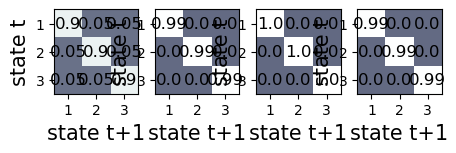

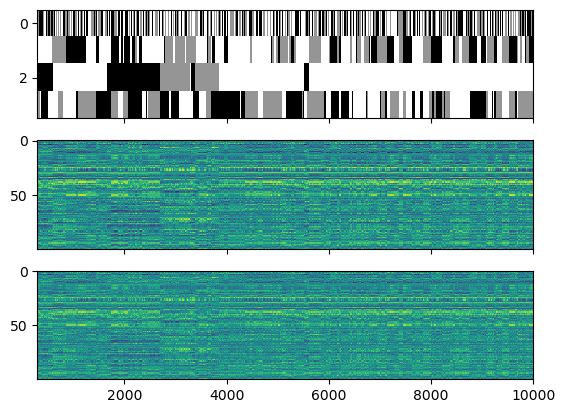

In [2]:
num_factors = 4
num_states = 3
emission_dim = 100
num_timesteps = 200000

emission_option='mixedsel' # the emissions from different factors are mixed
# emission_option='puresel'# each neuron only depends on one factor

hypers = dict(num_factors=num_factors,
              num_states=num_states,
              emission_dim=emission_dim)


initial_dist = np.ones((num_factors, num_states)) / num_states
transition_matrices=np.zeros((num_factors,num_states,num_states))
# for i in range(num_factors):
#     # transition_matrix = 0.9 * np.eye(num_states) + 0.1*np.random.rand(num_states,num_states)
#     # row_sums = transition_matrix.sum(axis=1)
#     # transition_matrix = transition_matrix /  row_sums[:, None]
#     epsi=10**(-i-1)
#     transition_matrix = (1-epsi) * np.eye(num_states)
#     mask = np.ones_like(transition_matrix, dtype=bool)
#     np.fill_diagonal(mask, False)   
#     transition_matrix[mask] = epsi/(num_states-1) 
#     # row_sums = transition_matrix.sum(axis=1)
#     # transition_matrix = transition_matrix /  row_sums[:, None]
#     transition_matrices[i]=transition_matrix

# use this below tog et 2 factors on the same timescale, see if you can recover them
for i in range(num_factors-1):
    # transition_matrix = 0.9 * np.eye(num_states) + 0.1*np.random.rand(num_states,num_states)
    # row_sums = transition_matrix.sum(axis=1)
    # transition_matrix = transition_matrix /  row_sums[:, None]
    epsi=10**(-i-1)
    transition_matrix = (1-epsi) * np.eye(num_states)
    mask = np.ones_like(transition_matrix, dtype=bool)
    np.fill_diagonal(mask, False)   
    transition_matrix[mask] = epsi/(num_states-1) 
    # row_sums = transition_matrix.sum(axis=1)
    # transition_matrix = transition_matrix /  row_sums[:, None]
    transition_matrices[i]=transition_matrix
transition_matrices[i+1]=transition_matrices[1]

if emission_option=='mixedsel':
    means = npr.randn(num_factors, num_states, emission_dim) # mixed selectivity
elif emission_option=='puresel':
    means = np.zeros((num_factors, num_states, emission_dim)) # pure selectivity
    for i in range(num_factors):
        indperm=np.random.permutation(np.arange(emission_dim))
        neuron_per_state=np.floor(emission_dim/num_states).astype(int)
        for i_st in range(num_states):
            means[i,i_st,indperm[i_st*neuron_per_state:(i_st+1)*neuron_per_state]]=npr.randn(neuron_per_state)
        means[i,num_states-1,indperm[(num_states-1)*neuron_per_state:len(indperm)]]=npr.randn(emission_dim-neuron_per_state*(num_states-1))
# variances = 0.1 * np.ones((num_factors, num_states, emission_dim))
variances=0.2*np.ones(emission_dim)

params = dict(initial_dist=initial_dist,
              transition_matrices=transition_matrices,
              means=means,
              variances=variances)

true_states = np.zeros((num_timesteps, num_factors), dtype=int)
emissions = np.zeros((num_timesteps, emission_dim))
expec_emissions = np.zeros((num_timesteps, emission_dim))

npr.seed(0)
for t in range(num_timesteps):
    for h in range(num_factors):
        if t > 0:
            true_states[t, h] = \
              npr.choice(num_states, p=transition_matrices[h, true_states[t-1, h]])
        
    # mean = np.zeros(emission_dim)
    # for h in range(num_factors):      
    #     mean += means[h, states[t,h], :]
    expec_emissions[t] = np.sum(means[np.arange(num_factors), true_states[t]], axis=0)
    emissions[t] = expec_emissions[t] + np.sqrt(variances) * npr.randn(emission_dim)

data={'emissions':emissions,'true_states':true_states,'expec_emissions':expec_emissions,'params':params}
x=np.save('data1.npy',data)



plt.figure(figsize=(5, 12))
for i in range(num_factors):
    ax = plt.subplot(1, num_factors, i+1)
    plot_trans_matrix(transition_matrices[i])

fig, axs = plt.subplots(3, 1, sharex=True)
axs[0].imshow(true_states.T, aspect="auto", interpolation="none", cmap="Greys")
axs[1].imshow(expec_emissions.T, aspect="auto", interpolation="none")
axs[2].imshow(emissions.T, aspect="auto", interpolation="none")

# axs[3].imshow(mean, aspect="auto", interpolation="none")

plt.xlim(300, 10000)

flat_one_hot_states=true2onehot_states(true_states)


# Model selection

1. Perform cross-validated ICA to select for the number of ICA sources $L$. Given the data $Y_{i,t}$ for neuron $i$ and time $t$, we perform ICA on the whitened data to obtain the $L$ sources $s_{l,t}$ and the mixing matrix $H_{i,l}$ with
$$
Y_{i,t}=\sum_{l=1}^{L}H_{i,l}S_{l,t}+Y_{mean} \ .
$$

2. On each of the sources $l=1,\ldots,L$, run model selection with a gaussian mixture model (GMM) to find the optimal number of mixtures $n_l$ that best describe that source. 

3. For each source $l$, fit an HMM with $m=1,\ldots,M_l$ states to each source $S_{l,t}$ and store posteriors and emissions
          $$
          S_{l,t}=\sum_{m=1}^{M_l}e_m^{(l)}p^{(l)}(m,t)
          $$
          where $\{e_m^{(l)},p^{(l)}(m,t)\}$ are the emissions and posterior probabilities for HMM state $m$ for source $l$.

4. Concatenate all posteriors from all HMM of all sources for a total of $S=\sum_{l=1}^L M_l$, and estimate their $S x S$ correlation matrix. Find groups of highly correlated posteriors (abs(corr)$>0.95$) representing identical copies of the same HMM state that was detected in more than one ICA source. For each group of highly correlated posteriors, keep only one copy and drop the rest, thus decreasing the number of total posteriors from S to $\hat S$.

5. Consider the $\hat S \times \hat S$ correlation matrix between the surviving posteriors, and now perform hierarchical clustering on it, to find $c=1,\ldots,C$ chains of most anticorrelated posteriors, each group with $N_c$ states. E.g., groups of posteriors with anticorrelation of $-0.5$ correspond to a Markov chain with 3 states. Normalize the posteriors within each chain such that $\sum_{n=1}^{N_c}p^{(c)}(n,t)=1$ for all $t$ and all chains $c$, so that the original data reads
$$
Y_{i,t}=\sum_{l=1}^{L}H_{i,l}S_{l,t}+Y_{mean} =\sum_{c=1}^C H_{i,c} \sum_{n=1}^{N_c}e_n^{(c)}p^{(c)}(n,t)
$$

6. Initialization of fHMM parameters. The procedure above defines an fHMM with **emissions** $E_i(n,c)$ for state $n$ in chain $c$ given by
$$
E_i(n,c)=H_{i,c}e_n^{(c)}+Y_{mean,i},
$$
**transition probabilities** $A_{nm}^{(c)}$ and initial distribution $\pi_n^{(c)}$ for the chain c obtained from the posteriors as:
$$
A_{nm} \ ,\qquad \pi_n^{(c)}=p^{(c)}(n,t=0) \ .
$$




# Step 1: select number of ICA sources

/Users/mazzu/opt/anaconda3/envs/ssm_dynamax/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/mazzu/opt/anaconda3/envs/ssm_dynamax/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/mazzu/opt/anaconda3/envs/ssm_dynamax/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/mazzu/opt/anaconda3/envs/ssm_dynamax/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/mazzu/opt/anaconda3/envs/ssm_

Optimal number of components based on the elbow method: 8


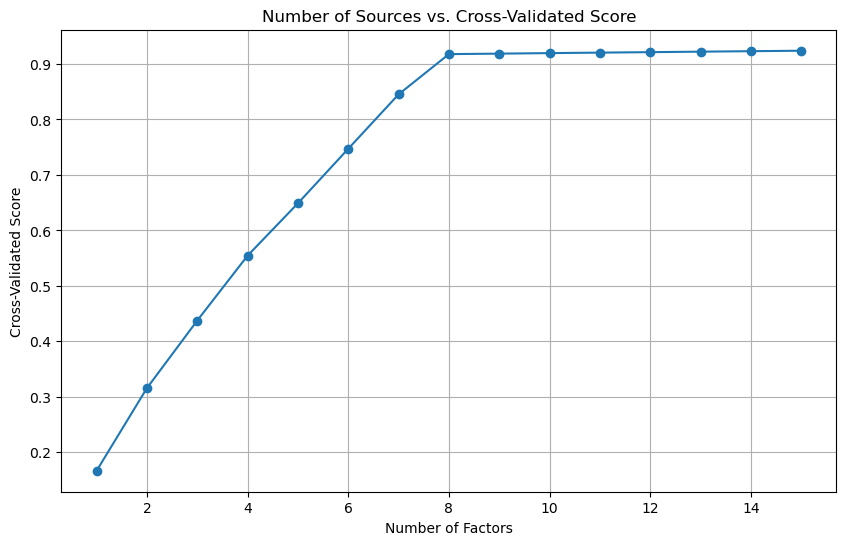

<Figure size 640x480 with 0 Axes>

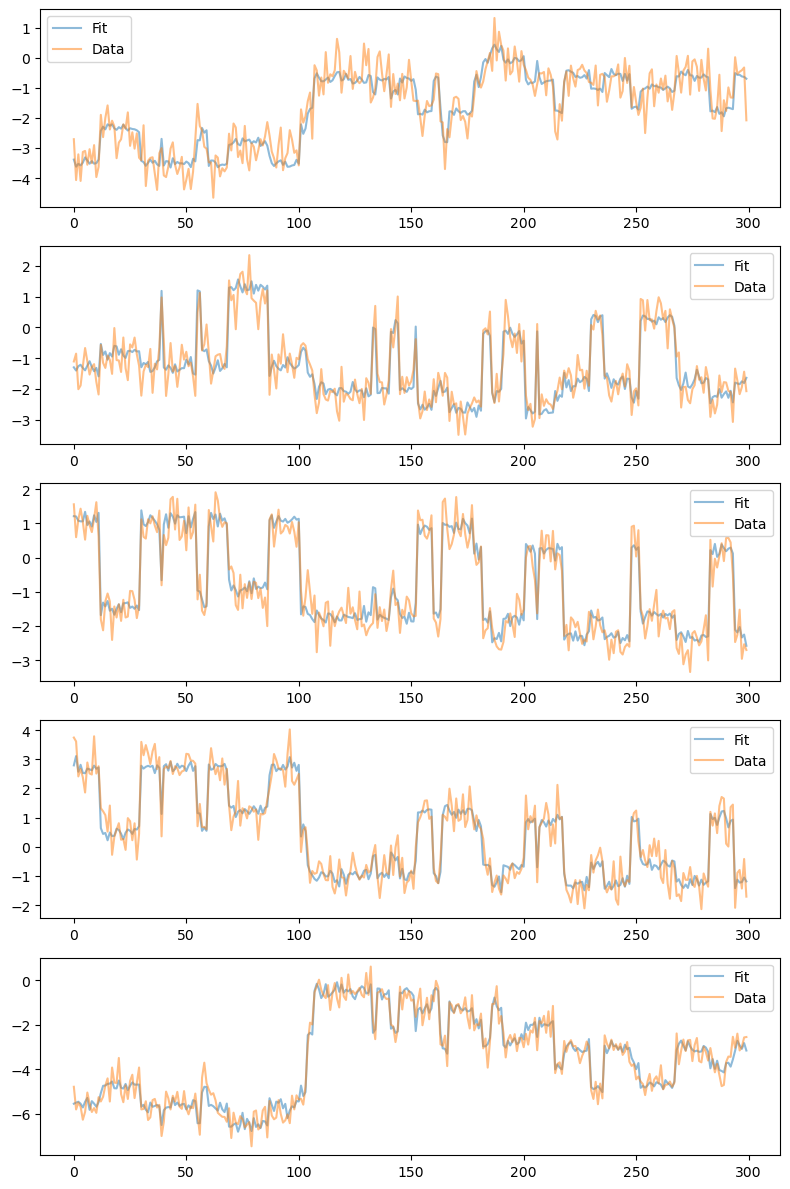

<Figure size 640x480 with 0 Axes>

In [3]:
emissions_data=emissions
MAX_runs=50
ica,optimal_n_components=model_sel_ICA(emissions_data,MAX_runs=50)
factors=ica.transform(emissions_data)
num_factors_FA=factors.shape[1]


## Step 1.1: Estimate timescale for each factor, cluster timescales

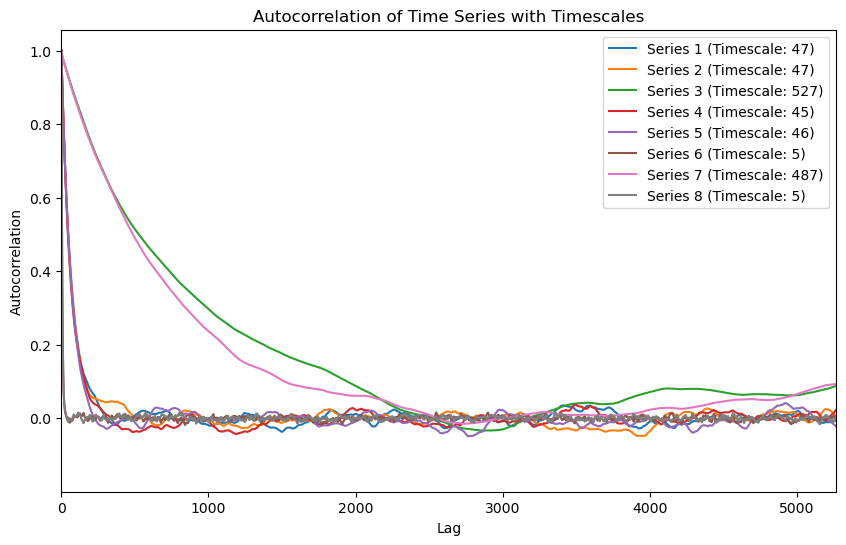

Timescales: [47, 47, 527, 45, 46, 5, 487, 5]


/Users/mazzu/opt/anaconda3/envs/ssm_dynamax/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mazzu/opt/anaconda3/envs/ssm_dynamax/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Optimal number of clusters: 3
Labels: [1 1 2 1 1 0 2 0]
Timescales: [47, 47, 527, 45, 46, 5, 487, 5]


/Users/mazzu/opt/anaconda3/envs/ssm_dynamax/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mazzu/opt/anaconda3/envs/ssm_dynamax/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mazzu/opt/anaconda3/envs/ssm_dynamax/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mazzu/opt/anaconda3/envs/ssm_dynamax/lib/python3.9/site-packages/sklearn/cluster/

<Figure size 640x480 with 0 Axes>

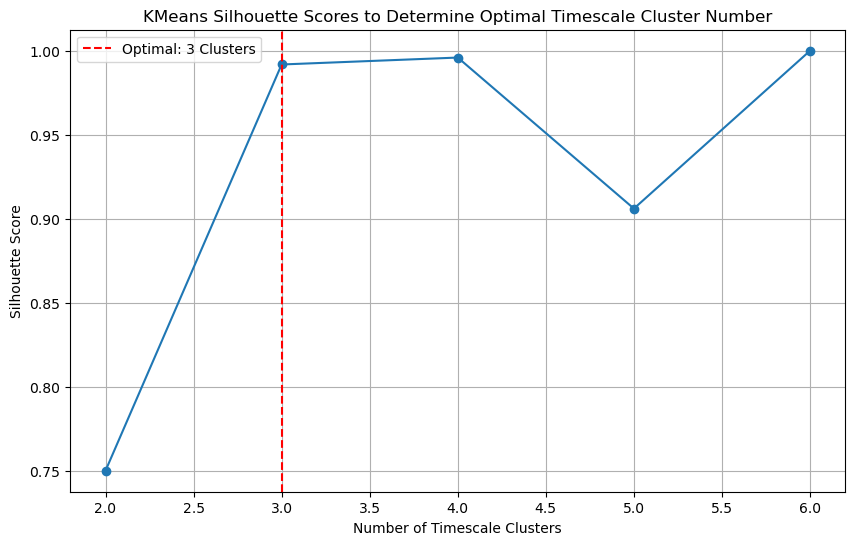

<Figure size 640x480 with 0 Axes>

In [4]:
timescales,labels,optimal_n_timescales=infer_timescales(factors)

# Step 2: Find best number of GMM for each ICA source

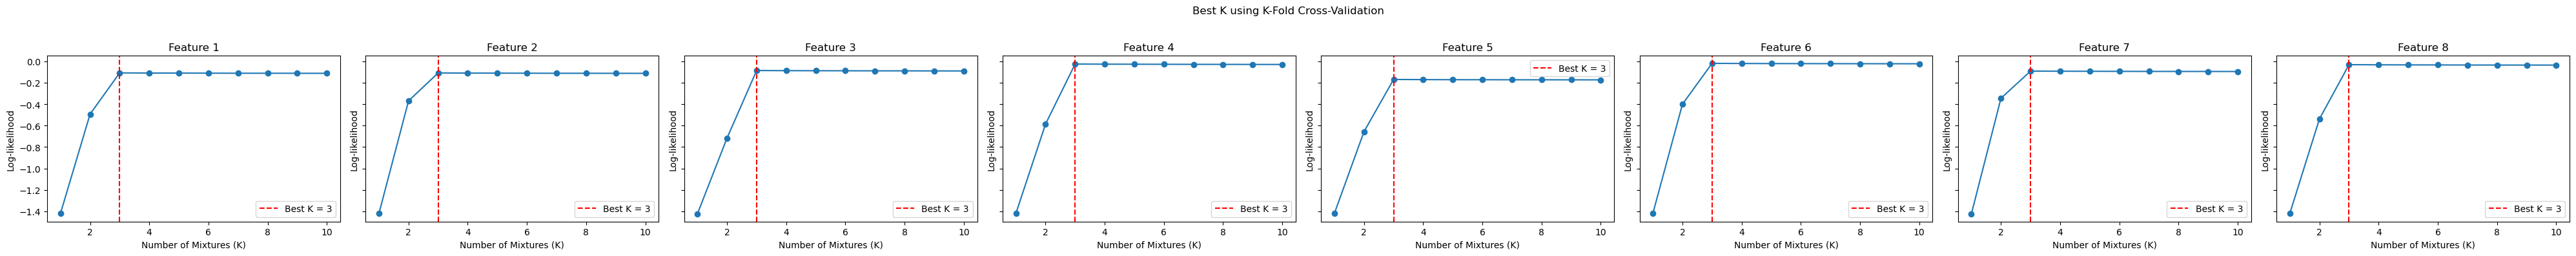

In [5]:

results,n_states_gmm = fit_GMM2sources_findNumStates(factors)

# Step 3: Fit an HMM to each source, with given number of states from step 2.

Converged to LP: 133682.4:   2%|▏         | 23/1000 [00:03<02:12,  7.37it/s]


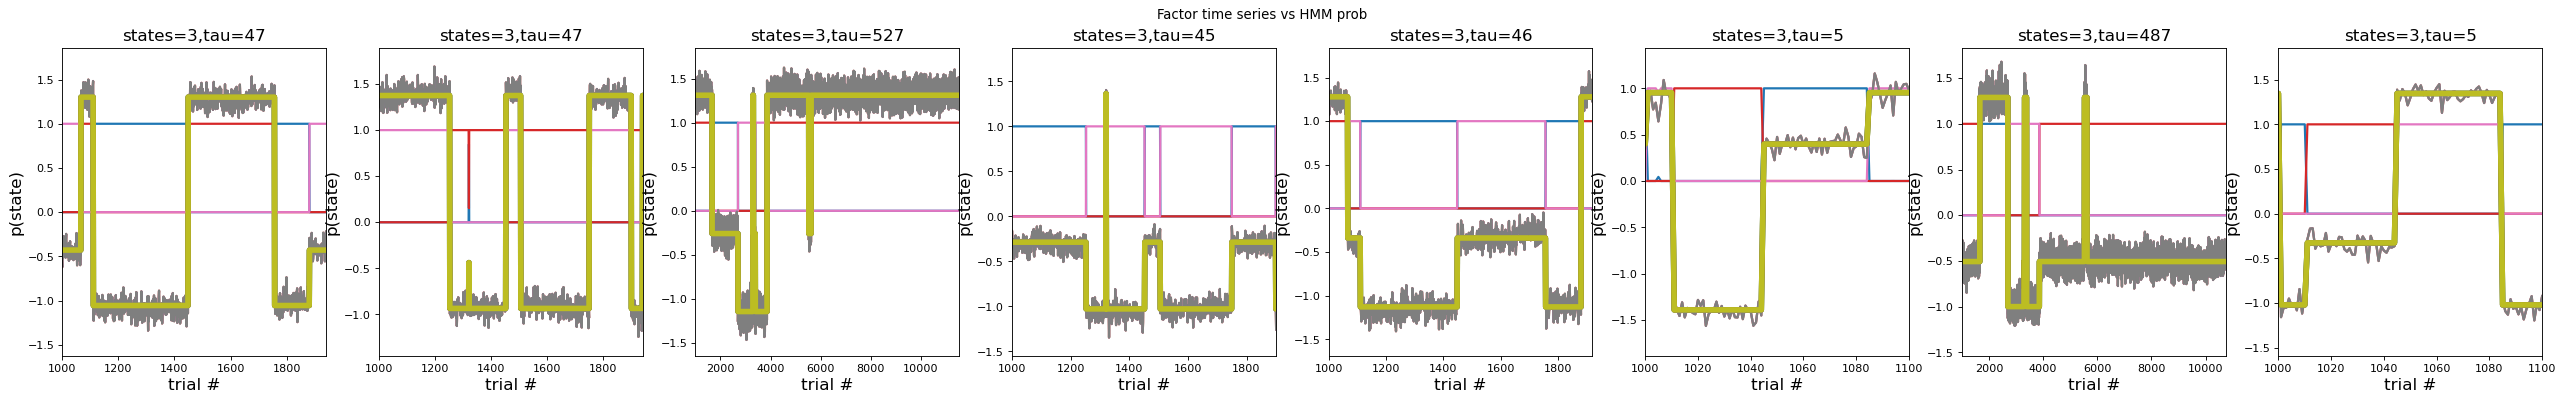

In [6]:

hmm_fits=fit_hmm_after_gmm(factors,n_states_gmm,timescales)


## Step 4.1: Find groups of copies of HMM posteriors (highly correlated) and remove them 

{0, 12}
{1, 14}
{2, 13}
{10, 3}
{11, 4}
{9, 5}
{18, 6}
{19, 7}
{8, 20}
{23, 15}
{16, 22}
{17, 21}


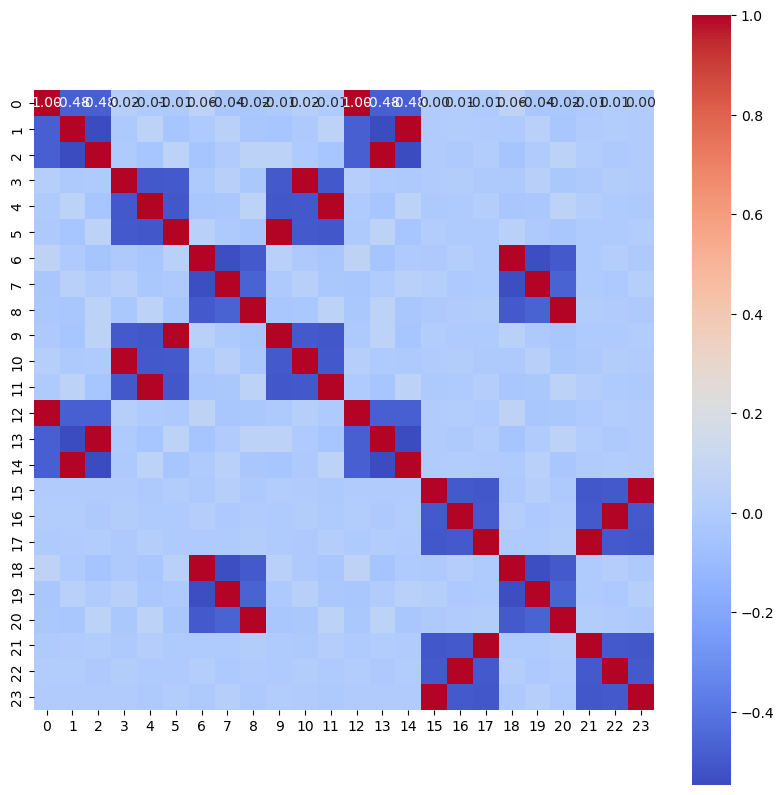

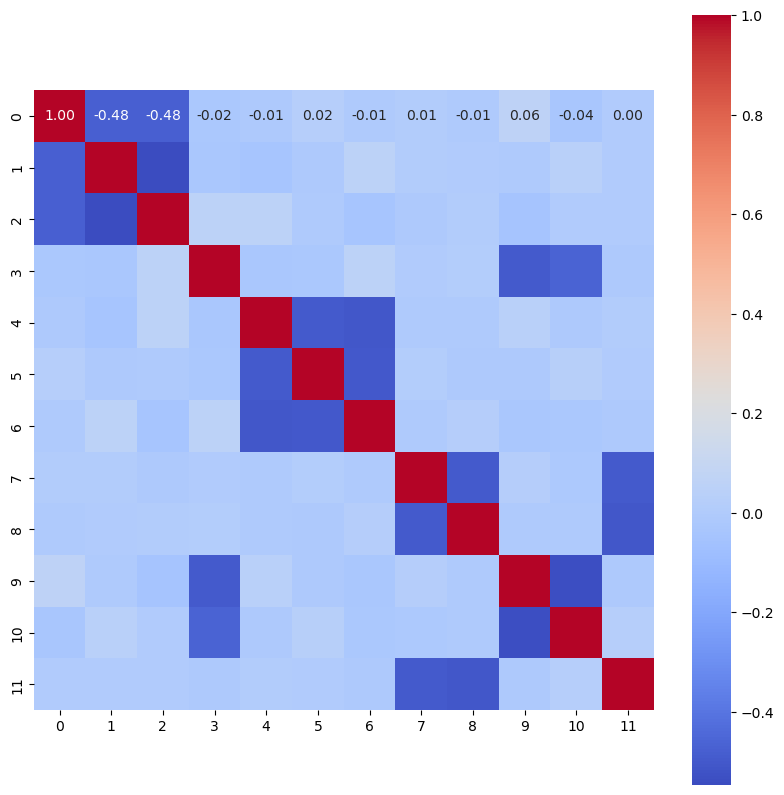

In [7]:
data_factors_to_keep,new_corr_matrix,data_factors=remove_duplicate_hmms(hmm_fits,labels)

## Step 5: Perform hierarchical clustering to find groups of anticorrelated posteriors 

/Users/mazzu/Library/CloudStorage/Dropbox/neuro/PROJECTS/factorial_hmm/utils_modelsel.py:302: RuntimeWarning: Mean of empty slice
  average = np.nanmean(matrix_copy)


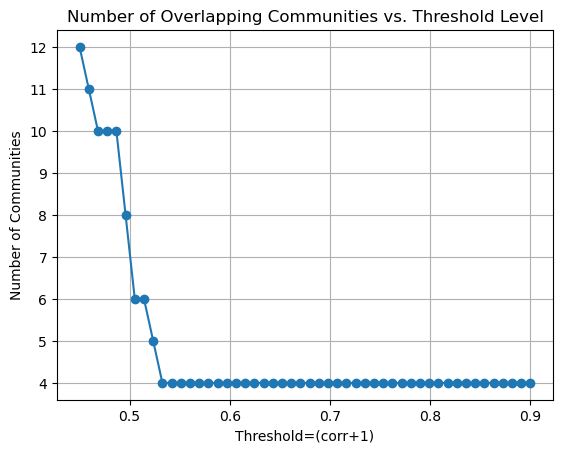

/Users/mazzu/Library/CloudStorage/Dropbox/neuro/PROJECTS/factorial_hmm/utils_modelsel.py:623: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{float(tick.get_text()) - 1:.2f}' for tick in plt.gca().get_yticklabels()])


<Figure size 640x480 with 0 Axes>

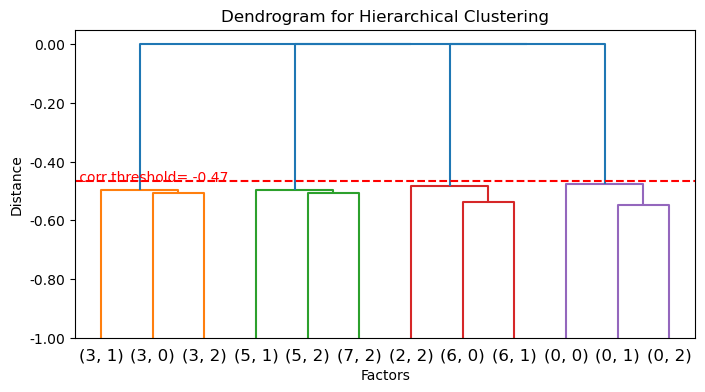

<Figure size 640x480 with 0 Axes>

In [8]:



correlation_matrix = new_corr_matrix
id_communities,mean_corr_communities,Z_communities=cluster_hmm(correlation_matrix,data_factors_to_keep)

## Step 6: Reconstruct HMM posteriors and parameters for fHMM initialization.

In [9]:


means_rec,posteriors_rec,transitions_rec,init_rec=reconstruct_parameters(id_communities,data_factors_to_keep,ica)
sigmas=emissions_data.std(axis=0)

## Compare reconstructed parameters with model parameters

In [13]:
compare_reconstructed_true(means_rec,posteriors_rec,data)

NameError: name 'compare_reconstructed_true' is not defined